# Fit harmonics to filtered $A_n$ data

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

#from soda.dataio.conversion import readotps

from scipy.optimize import fmin_powell, fmin, fmin_cg, fmin_ncg

from theano import shared
from theano import tensor as tt

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from mycurrents import oceanmooring as om
from soda.utils.harmonic_analysis import harmonic_fit_array
from soda.utils.mysignal import power_spectra

from scipy import signal

from tqdm import tqdm

import matplotlib as mpl

In [3]:
%matplotlib notebook

In [4]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 'large'

In [ ]:
#ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_Fitted_Buoyancy_wout_motion.nc'
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')
ds1

In [ ]:
# Filter each time series and concatenate
A1 = om.OceanMooring(ds1.time.values, ds1['A_n'][:,0],0.0)
A2 = om.OceanMooring(ds2.time.values, ds2['A_n'][:,0],0.0)

A1f = om.OceanMooring(A1.t, A1.filt((34*3600, 6*3600), btype='band'), 0.0)
A2f = om.OceanMooring(A2.t, A2.filt((34*3600, 6*3600), btype='band'), 0.0)

A_n = A1f.concat(A2f)
A_n_1h_6 = xr.DataArray(A_n.y[::60], dims=('time'), coords={'time':A_n.t[::60]})

A1f = om.OceanMooring(A1.t, A1.filt((34*3600, 3*3600), btype='band'), 0.0)
A2f = om.OceanMooring(A2.t, A2.filt((34*3600, 3*3600), btype='band'), 0.0)

A_n = A1f.concat(A2f)
A_n_1h = xr.DataArray(A_n.y[::60], dims=('time'), coords={'time':A_n.t[::60]})



# A_n_1h.loc['2016-09-15':'2016-10-31']=np.nan

#A_n_1h = A_n_1h.sel(time=slice('2016-11-02','2017-05-02'))

<IPython.core.display.Javascript object>


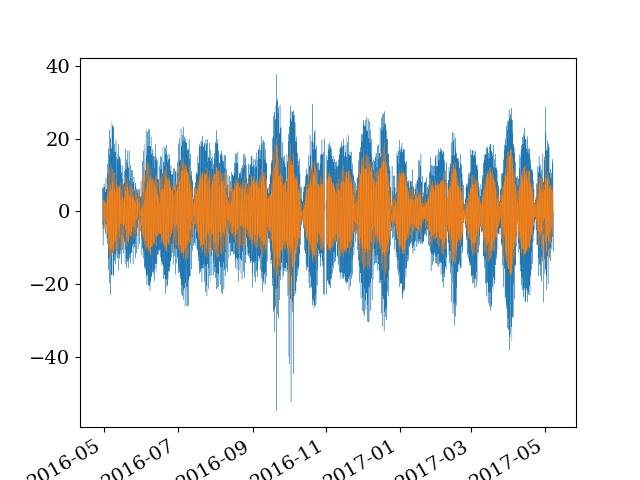

In [6]:
plt.figure()
A_n_1h.plot(lw=0.25)
A_n_1h_6.plot(lw=0.2)


In [7]:
def sine_model(beta_s, ff, t):
    n = len(ff)

    result = beta_s[0]*np.ones_like(t)
    for ii in range(0,n):
        result += beta_s[2*ii+1]*np.cos(ff[ii] * t) + beta_s[2*ii+2]*np.sin(ff[ii]*t)

    return result

def sine_model_pm(beta_s, ff, t):
    n = len(ff)

    result = beta_s[0] + beta_s[1]*t
    for ii in range(0,n):
        result += beta_s[2*ii+2]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+3]*pm.math.sin(ff[ii]*t)

    return result

def sine_model_notrend_pm(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0]+0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+2]*pm.math.sin(ff[ii]*t)

    return result
    
def cosine_model_pm(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0]+0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*pm.math.cos(ff[ii] * t - beta_s[2*ii+2])

    return result

def sine_model_notrend(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0] + 0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*np.cos(ff[ii] * t) + beta_s[2*ii+2]*np.sin(ff[ii]*t)

    return result    

def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    #result = np.zeros(t.shape)
    result = beta_s[0] + 0*t

    for ii in range(0,n):
        result += beta_s[2*ii+1]*np.cos(ff[ii] * t) + beta_s[2*ii+2]*np.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = np.zeros(t.shape) # Imaginary mean component is zero

    for ii in range(0,n):
        result_i += beta_s[2*ii+1]*np.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+2]*np.sin(ff[ii]*t + np.pi/2)
    
    return np.sqrt(result*result + result_i*result_i)

# def sine_model_envelope_pm(beta_s, ff, t):
#     n = len(ff)
    
#     #result = t*0
    
#     result = tt.zeros(t.shape)

#     for ii in range(0,n):
#         result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
#     # Compute the imaginary part by adding a 90 degree phase shift
#     #result_i = t*0
#     result_i = tt.zeros(t.shape)

#     for ii in range(0,n):
#         result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
#             + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
#     return pm.math.sqrt(result*result + result_i*result_i)

In [8]:
# Create a function with similar functionality as harmonic_fit in soda
def harmonic_fit_mcmc(time, X, frq, mask=None, axis=0, basetime=None,         **kwargs):
    """
    Harmonic fitting using Bayesian inference
    """
    tday = 86400.
    # Convert the time to days
    dtime = SecondsSince(time, basetime=basetime )
    
    
    # Generate initvalues from least-squares fitting
    ts = timeseries(time, X)
    amp, phs, _, _, h_lsq, err = ts.tidefit(frqnames=names)
    
    initvals = {'beta_mean':0.}
    initvals = {'sigma':1.}

    ii=-1
    for aa, pp in zip(amp,phs):
        ii+=1
        initvals.update({'beta_amp_%d'%ii:aa})
        initvals.update({'beta_phs_%d'%ii:pp})
    print(initvals)

    
    dtime /= tday
    
    # Convert the frequencies to radians / day
    omega = [ff*tday for ff in frq]
    #omega = frq
    
    # Number of parameters
    n_params = 2*len(omega) + 1
    
    print('Number of Parametrs: %d\n'%n_params, omega)

    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables
        BoundNormal = pm.Bound(pm.Normal, lower=0.0)

        # Mean
        beta_mean = pm.Normal('beta_mean', mu=0, sd=1)
        # Trend
        #beta_linear = pm.Normal('beta_linear', mu=0, sd=1.)

        #beta_s = [beta_mean, beta_linear]
        beta_s=[beta_mean]

        # Harmonics
        for n in range(0,2*len(omega),2):
            beta_s.append(pm.Normal('beta_%d_re'%(n//2), mu=1., sd = 5.))
            beta_s.append(pm.Normal('beta_%d_im'%(n//2), mu=1., sd = 5.))
        #for n in range(0,len(omega)):
        #    beta_s.append(BoundNormal('beta_amp_%d'%n,mu=1., sd=10.))
        #    #beta_s.append(pm.Uniform('beta_amp_%d'%n,lower=0, upper=30))
        #    beta_s.append(pm.Uniform('beta_phs_%d'%n, lower=-np.pi, upper=np.pi))

        ###
        # Generate the likelihood function using the deterministic variable as the mean
        #mu_x = cosine_model_pm(beta_s, omega, dtime)
        #mu_x = pm.Deterministic('mu_x', cosine_model_pm(beta_s, omega, dtime))
        mu_x = sine_model_notrend_pm(beta_s, omega, dtime)

        
        #sigma = BoundNormal('sigma', mu=1.,sd=0.25)
        sigma = pm.HalfNormal('sigma',5.)
        
        #sigma = 1.0
        X_obs = pm.Normal('X_obs', mu=mu_x, sd=sigma, observed=X)
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=1, observed=X)
        
        mp = pm.find_MAP()
        print(mp)
        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        trace = pm.sample(500, tune=1000, start = start, step=step, cores=2,
                         )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
    
    
    # Return the trace and the parameter stats
    return trace,  my_model, omega, dtime, h_lsq

In [9]:
# Create a function with similar functionality as harmonic_fit in soda
def harmonic_fit_mcmc_ar1(time, X, frq, mask=None, axis=0, basetime=None,         **kwargs):
    """
    Harmonic fitting using Bayesian inference
    
    Model the errors using an auto-regressive model
    """
    tday = 86400.
    # Convert the time to days
    dtime = SecondsSince(time, basetime=basetime )
    nt = dtime.shape[0]
    
    
    # Generate initvalues from least-squares fitting
    ts = timeseries(time, X)
    amp, phs, _, _, h_lsq, err = ts.tidefit(frqnames=names)
    
    initvals = {'beta_mean':0.}
    initvals = {'sigma':1.}

    ii=-1
    for aa, pp in zip(amp,phs):
        ii+=1
        initvals.update({'beta_amp_%d'%ii:aa})
        initvals.update({'beta_phs_%d'%ii:pp})
    print(initvals)

    
    dtime /= tday
    
    # Convert the frequencies to radians / day
    omega = [ff*tday for ff in frq]
    #omega = frq
    
    # Number of parameters
    n_params = 2*len(omega) + 1
    
    print('Number of Parametrs: %d\n'%n_params, omega)

    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables
        BoundNormal = pm.Bound(pm.Normal, lower=0.0)

        # Mean
        beta_mean = pm.Normal('beta_mean', mu=0, sd=1)
        # Trend
        #beta_linear = pm.Normal('beta_linear', mu=0, sd=1.)

        #beta_s = [beta_mean, beta_linear]
        beta_s=[beta_mean]

        # Harmonics
        for n in range(0,2*len(omega),2):
            beta_s.append(pm.Normal('beta_%d_re'%(n//2), mu=1., sd = 5.))
            beta_s.append(pm.Normal('beta_%d_im'%(n//2), mu=1., sd = 5.))
        #for n in range(0,len(omega)):
        #    beta_s.append(BoundNormal('beta_amp_%d'%n,mu=1., sd=10.))
        #    #beta_s.append(pm.Uniform('beta_amp_%d'%n,lower=0, upper=30))
        #    beta_s.append(pm.Uniform('beta_phs_%d'%n, lower=-np.pi, upper=np.pi))

        ###
        # Generate the likelihood function using the deterministic variable as the mean
        #mu_x = cosine_model_pm(beta_s, omega, dtime)
        #mu_x = pm.Deterministic('mu_x', cosine_model_pm(beta_s, omega, dtime))
        mu_x = sine_model_notrend_pm(beta_s, omega, dtime)

        
        #sigma = BoundNormal('sigma', mu=1.,sd=0.25)
        #sigma = pm.HalfNormal('sigma',5.)
        
        #sigma = 1.0
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=sigma, observed=X)
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=1, observed=X)
        
        # Use an autoregressive model for the error term
        beta = pm.Normal('beta', mu=0, sigma=1.)
        sigma = pm.HalfNormal('sigma',1.)

        err = pm.AR('err', beta, sigma=sigma, shape=nt)

        #sigma = pm.HalfNormal('sigma',1.)
        #X_obs = pm.Normal('X_obs', mu=mu_x+err, sd=sigma, observed=X)
        #X_obs = pm.Deterministic('X_obs', mu_x+err)
        
        #beta = pm.Normal('beta', mu=0, sigma=1.)
        #         sigma = pm.HalfNormal('sigma',1.)

        #         err = pm.AR('err', mu_x, sigma=sigma, observed=X)
        
        mp = pm.find_MAP()
        print(mp)
        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        trace = pm.sample(500, tune=1000, start = start, step=step, cores=2,
                         )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
    
    
    # Return the trace and the parameter stats
    return trace,  my_model, omega, dtime, h_lsq

In [102]:
# tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1','MA2','MB2']
# tidecons = ['M2','S2',] # Non-station harmonics
# # tidecons = ['M2','S2',]
# tidecons_2 = ['N2','K1','O1'] # Stationary harmonics

# frq,names = getTideFreq(tidecons)
# frq2,names = getTideFreq(tidecons_2)


# # Add on long-term modulations
# tdaysec = 86400
# fA = 2*np.pi/(365*tdaysec)
# # fSA = 2*np.pi/(182*tdaysec)
# # fTA = 2*np.pi/(120*tdaysec)
# # f90 = 2*np.pi/(90*tdaysec)

# # longperiods = [0, fA, fSA, fTA]
# #longperiods = [0, 2*np.pi/(365*tdaysec), 2*np.pi/(182*tdaysec), 2*np.pi/(120*tdaysec)]
# # longperiods = [0, 2*np.pi/(182*tdaysec),]
# #longperiods = [0,  2*np.pi/(120*tdaysec), 2*np.pi/(30*tdaysec)]
# # longperiods = [-fTA, -fSA, -fA, 0, fA, fSA, fTA]
# # longperiods = [0, fA, fSA]
# longperiods = [-3*fA, -2*fA, -1*fA, 0, 1*fA, 2*fA, 3*fA]

# # longperiods = [-4*fA, -3*fA, -2*fA, 0, 2*fA, 3*fA, 4*fA]

# sitename = 'M2S2nonstat_N2K1O1'
# #sitename = 'M2S2_lowfreq_90d'
# # outputh5 = '../inputs/a0_samples_harmonicfit_M2S2lowfreq_ATASA_12month.h5'
# outputh5 = '../inputs/a0_samples_harmonicfit_{}_12month.h5'.format(sitename)
# #outputh5 = '../inputs/a0_samples_harmonicfit_M2S2K1O1lowfreq_12month.h5'

# frq_lt = []
# for ff in frq:
#     for ll in longperiods:
#         frq_lt.append(ff+ll)
        
# # Append the stationary harmonics
# for ff in frq2:
#     frq_lt.append(ff)

######
tidecons = ['M2','S2','N2','K1','O1'] # Non-stationary harmonics
# tidecons = ['M2','S2',]

frq,names = getTideFreq(tidecons)


# Add on long-term modulations
tdaysec = 86400
fA = 2*np.pi/(365*tdaysec)
longperiods = [-3*fA, -2*fA, -1*fA, 0, 1*fA, 2*fA, 3*fA]

# longperiods = [-4*fA, -3*fA, -2*fA, 0, 2*fA, 3*fA, 4*fA]

sitename = 'M2S2N2K1O1nonstat'
#sitename = 'M2S2_lowfreq_90d'
# outputh5 = '../inputs/a0_samples_harmonicfit_M2S2lowfreq_ATASA_12month.h5'
outputh5 = '../inputs/a0_samples_harmonicfit_{}_12month.h5'.format(sitename)
#outputh5 = '../inputs/a0_samples_harmonicfit_M2S2K1O1lowfreq_12month.h5'

frq_lt = []
for ff in frq:
    for ll in longperiods:
        frq_lt.append(ff+ll)
        
######
# sitename = 'M2S2N2K2K1O1P1Q1'
# outputh5 = '../inputs/a0_samples_harmonicfit_{}_12month.h5'.format(sitename)
# tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']
# # # tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1','MA2','MB2']
# frq_lt,names = getTideFreq(tidecons)

#####

basetime = datetime(2016,1,1)

# X_sd = A_n_1h.y.std()
# X_mu = A_n_1h.y.mean()

X_sd = 1
X_mu = 0

idx = ~np.isnan(A_n_1h.values)
X = A_n_1h.values[idx] - X_mu
X /= X_sd
trace, my_model, omega, dtime, h_lsq = harmonic_fit_mcmc(A_n_1h.time.values[idx], X, frq_lt, basetime=basetime)
# trace, my_model, omega, dtime, h_lsq = harmonic_fit_mcmc_ar1(A_n_1h.time.values[idx], X, frq_lt, basetime=basetime)

pm.summary(trace)

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


{'sigma': 1.0, 'beta_amp_0': 11.15472669117238, 'beta_phs_0': -1.3637852136559072, 'beta_amp_1': 5.2261228343366, 'beta_phs_1': 0.32077666395310456, 'beta_amp_2': 2.0400081373152767, 'beta_phs_2': -3.059360373809417, 'beta_amp_3': 1.2120685971734526, 'beta_phs_3': 1.979491284290308, 'beta_amp_4': 0.6956792689490549, 'beta_phs_4': -1.8626936969099497}
Number of Parametrs: 71
 [12.08919055778369, 12.10640476410473, 12.123618970425769, 12.14083317674681, 12.15804738306785, 12.175261589388889, 12.192475795709928, 12.514727995396052, 12.531942201717092, 12.549156408038133, 12.566370614359172, 12.583584820680212, 12.600799027001253, 12.618013233322293, 11.861163416674335, 11.878377622995377, 11.895591829316416, 11.912806035637455, 11.930020241958495, 11.947234448279536, 11.964448654600575, 6.248745463156895, 6.265959669477934, 6.283173875798974, 6.300388082120014, 6.317602288441054, 6.334816494762094, 6.352030701083134, 5.7888024756636725, 5.806016681984713, 5.823230888305753, 5.840445094626

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -27,267, ||grad|| = 7.2329: 100%|██████████| 26/26 [00:03<00:00,  8.46it/s]   
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'beta_mean': array(-0.00576128), 'beta_0_re': array(-1.40000354), 'beta_0_im': array(2.02223581), 'beta_1_re': array(2.53028754), 'beta_1_im': array(-0.42305579), 'beta_2_re': array(1.1376199), 'beta_2_im': array(-1.24494405), 'beta_3_re': array(2.58076119), 'beta_3_im': array(10.91892875), 'beta_4_re': array(1.90069646), 'beta_4_im': array(0.17894212), 'beta_5_re': array(2.62791674), 'beta_5_im': array(-0.56260957), 'beta_6_re': array(-0.27124384), 'beta_6_im': array(-3.48528211), 'beta_7_re': array(-0.00954814), 'beta_7_im': array(1.19691925), 'beta_8_re': array(0.05675686), 'beta_8_im': array(-1.081811), 'beta_9_re': array(0.7432593), 'beta_9_im': array(-0.45039623), 'beta_10_re': array(4.95530601), 'beta_10_im': array(1.67903849), 'beta_11_re': array(0.793227), 'beta_11_im': array(1.40630097), 'beta_12_re': array(-0.3891461), 'beta_12_im': array(-2.24700956), 'beta_13_re': array(-1.3229377), 'beta_13_im': array(-0.88949873), 'beta_14_re': array(-0.2467511), 'beta_14_im': array(-0.

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_34_im, beta_34_re, beta_33_im, beta_33_re, beta_32_im, beta_32_re, beta_31_im, beta_31_re, beta_30_im, beta_30_re, beta_29_im, beta_29_re, beta_28_im, beta_28_re, beta_27_im, beta_27_re, beta_26_im, beta_26_re, beta_25_im, beta_25_re, beta_24_im, beta_24_re, beta_23_im, beta_23_re, beta_22_im, beta_22_re, beta_21_im, beta_21_re, beta_20_im, beta_20_re, beta_19_im, beta_19_re, beta_18_im, beta_18_re, beta_17_im, beta_17_re, beta_16_im, beta_16_re, beta_15_im, beta_15_re, beta_14_im, beta_14_re, beta_13_im, beta_13_re, beta_12_im, beta_12_re, beta_11_im, beta_11_re, beta_10_im, beta_10_re, beta_9_im, beta_9_re, beta_8_im, beta_8_re, beta_7_im, beta_7_re, beta_6_im, beta_6_re, beta_5_im, beta_5_re, beta_4_im, beta_4_re, beta_3_im, beta_3_re, beta_2_im, beta_2_re, beta_1_im, beta_1_re, beta_0_im, beta_0_re, beta_mean]
Sampling 2 chains: 100%|██████████| 3000/3000 [51:44<00:00,  1.68draws/s]  


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_mean,-0.005559,0.054326,0.001053,-0.121193,0.089910,3018.018060,0.999165
beta_0_re,-1.401259,0.075665,0.001831,-1.547349,-1.253088,1954.490091,0.999059
beta_0_im,2.019905,0.075429,0.001673,1.861445,2.156054,2192.184646,0.999119
beta_1_re,2.534819,0.074643,0.001842,2.389761,2.691553,1669.084425,0.999001
beta_1_im,-0.423045,0.075823,0.001682,-0.556727,-0.265775,2621.716971,0.999163
beta_2_re,1.138669,0.075918,0.001690,0.982268,1.273072,2697.919943,0.999769
beta_2_im,-1.243604,0.079942,0.001586,-1.417217,-1.093500,2748.808744,0.999213
beta_3_re,2.579792,0.075512,0.001485,2.449741,2.745411,2864.282633,0.999412
beta_3_im,10.920658,0.079413,0.001594,10.773132,11.072553,3022.922813,0.999000
beta_4_re,1.900713,0.072565,0.001764,1.762204,2.042643,1759.603547,0.999005


In [103]:
# tnew = rhotime
# tsecnew = SecondsSince(tnew,basetime=basetime)
# tdaynew = tsecnew/86400.
# tdays.set_value(tdaynew)

tnew = A_n_1h.time.values[idx]
# Use the built-in function for prediction
nsamples = 500
ppc = pm.sample_posterior_predictive(trace, model=my_model, samples=nsamples)

a0_pred = ppc['X_obs']*X_sd + X_mu

err = np.median(a0_pred,axis=0) - A_n_1h.values[idx]

100%|██████████| 500/500 [00:16<00:00, 29.65it/s]


<IPython.core.display.Javascript object>


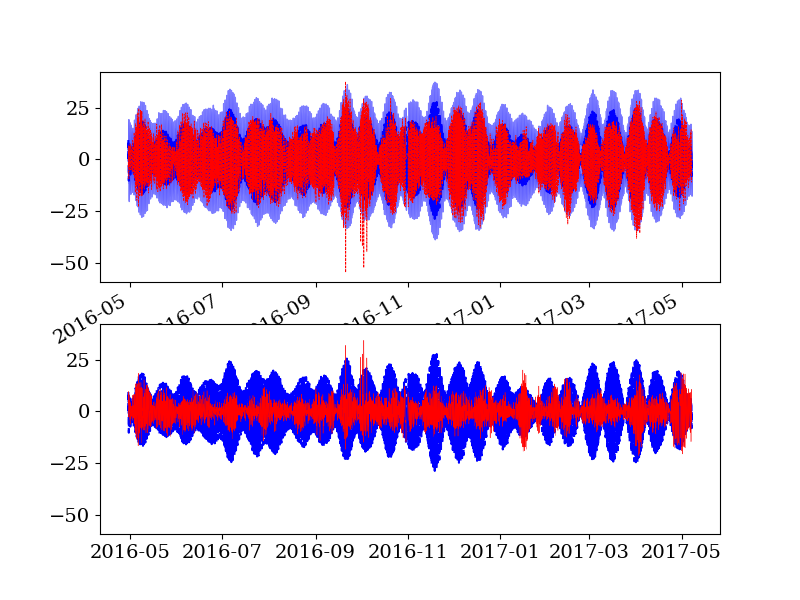

In [104]:
plt.figure(figsize=(8,6))

ax1=plt.subplot(211)
plt.plot(tnew, np.median(a0_pred,axis=0),'b--')
plt.fill_between(tnew, np.percentile(a0_pred,2.5,axis=0),\
                 np.percentile(a0_pred,97.5,axis=0),color='b',alpha=0.5)

#plt.plot(tnew, trace['err'].mean(axis=0),'k')

A_n_1h.plot(color='r',ls='--',lw=0.5)

plt.subplot(212,sharex=ax1, sharey=ax1)
plt.plot(tnew, np.median(a0_pred,axis=0),'b--')

plt.plot(tnew, err,'r',lw=0.3)

<IPython.core.display.Javascript object>


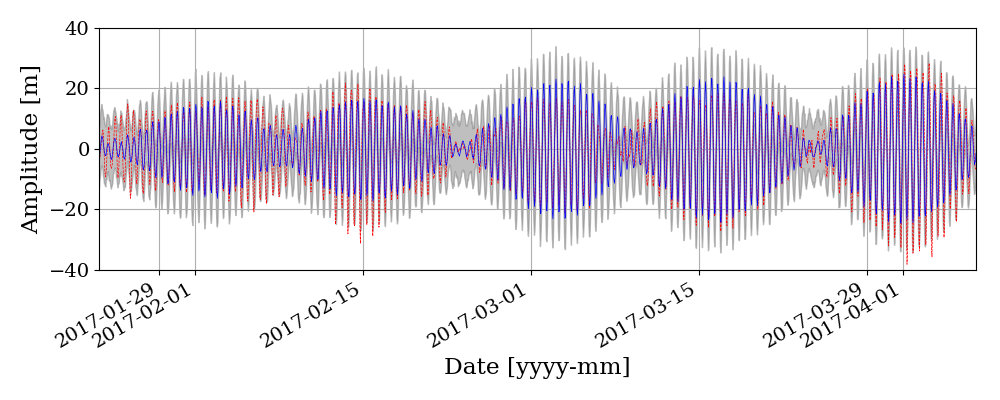

In [105]:
plt.figure(figsize=(10,4))

A_n_1h.plot(color='r',ls='--',lw=0.5)

plt.plot(tnew, np.median(a0_pred,axis=0),'b',lw=0.5)
plt.fill_between(tnew, np.percentile(a0_pred,2.5,axis=0),\
                 np.percentile(a0_pred,97.5,axis=0),color='0.5',alpha=0.5)

plt.ylim(-40,40)
plt.xlim(datetime(2017,1,24),datetime(2017,4,7))
plt.grid(b=True)
plt.xlabel('Date [yyyy-mm]')
plt.ylabel('Amplitude [m]')
plt.tight_layout()


plt.savefig('../FIGURES/a0_harmonic_zoom_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/a0_harmonic_zoom_{}.pdf'.format(sitename),dpi=150)

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


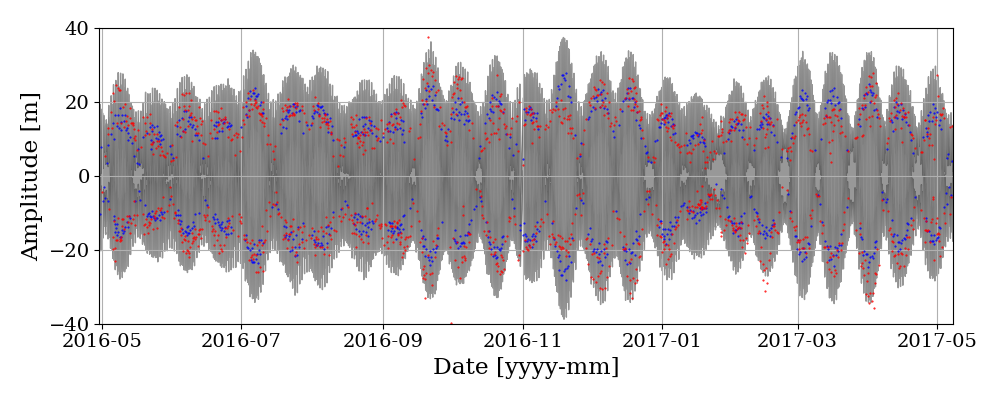

In [106]:
# plot the min/max only
a0_mean = np.median(a0_pred,axis=0)
idx1 = signal.find_peaks_cwt(a0_mean, np.arange(1,3))
idx2 = signal.find_peaks_cwt(-a0_mean, np.arange(1,3))

plt.figure(figsize=(10,4))
plt.plot(tnew[idx1],a0_mean[idx1],'b.',ms=1)
plt.plot(tnew[idx2],a0_mean[idx2],'b.',ms=1)

idx1 = signal.find_peaks_cwt(A_n_1h.values, np.arange(1,3))
idx2 = signal.find_peaks_cwt(-A_n_1h.values, np.arange(1,3))


plt.plot(A_n_1h.time[idx1],A_n_1h.values[idx1],'r.',ms=1)
plt.plot(A_n_1h.time[idx2],A_n_1h.values[idx2],'r.',ms=1)

plt.fill_between(tnew, np.percentile(a0_pred,2.5,axis=0),\
                 np.percentile(a0_pred,97.5,axis=0),color='0.2',alpha=0.5)

plt.ylim(-40,40)
plt.xlim(tnew[0],tnew[-1])
plt.grid(b=True)
plt.xlabel('Date [yyyy-mm]')
plt.ylabel('Amplitude [m]')
plt.tight_layout()

plt.savefig('../FIGURES/a0_harmonic_timeseries_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/a0_harmonic_timeseries_{}.pdf'.format(sitename),dpi=150)

In [107]:
# Fixed prediction time
rhotime = pd.date_range('2016-05-01','2017-05-02',freq='D').values
rhotime.shape

(367,)

In [108]:
#tnew = A_n_1h.time.values[idx]
tnew = rhotime
print(basetime)
tsecnew = SecondsSince(tnew,basetime=basetime)
tdaynew = tsecnew/86400.
nt = tnew.shape[0]

# Extract the amplitude envelope from the trace
nsamples = len(trace)
a0_pred = np.zeros((nsamples,nt))
for nn in tqdm(range(nsamples)):
    mytrace = trace[nn]
    betas =[mytrace['beta_mean']]
    for ii in range(len(omega)):
        betas.append(mytrace['beta_{}_re'.format(ii)])
        betas.append(mytrace['beta_{}_im'.format(ii)])

    env = sine_model_envelope(betas, omega, tdaynew)
    # Add the noise on
    env += np.random.normal(scale=mytrace['sigma']*0.5,size=(nt,))
    a0_pred[nn,:] = env

# plt.figure()    
# plt.plot(tnew, np.median(a0_pred,axis=0),'b--')
# plt.fill_between(tnew, np.percentile(a0_pred,0.5,axis=0),\
#                  np.percentile(a0_pred,99.5,axis=0),color='b',alpha=0.5)
# plt.fill_between(tnew, np.min(a0_pred,axis=0),\
#                  np.max(a0_pred,axis=0),color='b',alpha=0.3)



  8%|▊         | 41/500 [00:00<00:01, 404.12it/s]

2016-01-01 00:00:00


100%|██████████| 500/500 [00:01<00:00, 444.55it/s]


<IPython.core.display.Javascript object>


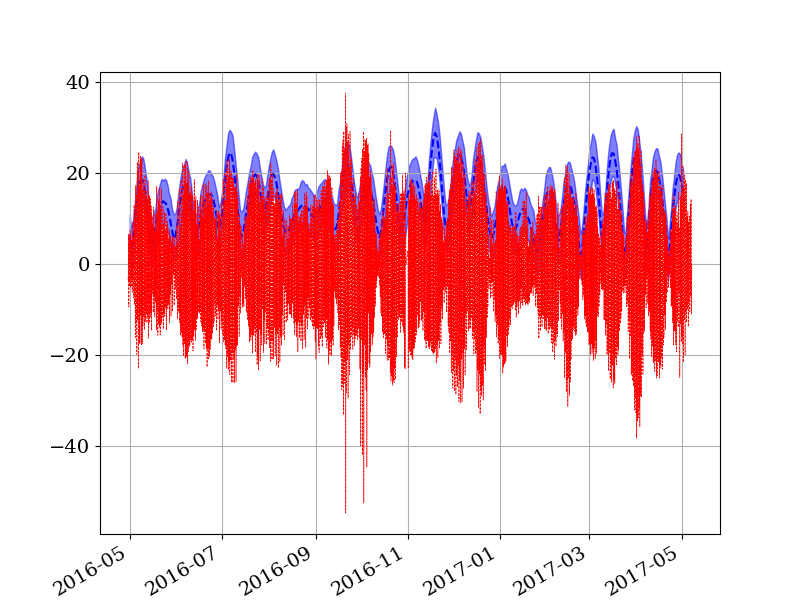

In [109]:
plt.figure(figsize=(8,6))

plt.plot(tnew, np.median(a0_pred,axis=0),'b--')
plt.fill_between(tnew, np.percentile(a0_pred,2.5,axis=0),\
                 np.percentile(a0_pred,97.5,axis=0),color='b',alpha=0.5)

A_n_1h.plot(color='r',ls='--',lw=0.5)

# plt.fill_between(tnew, np.min(a0_pred,axis=0),\
#                  np.max(a0_pred,axis=0),color='b',alpha=0.3)
plt.grid(b=True)

# Plot the power spectrum with the individual freqencies plus posterior distributions

In [110]:
def power_spectra_w(tsec, u_r, window=np.hanning, K=3, power=2., axis=-1):
    """
    Calculates the power spectral density from a real valued quanity
    
    """
    
    M = tsec.shape[0]
    dt = tsec[1]-tsec[0]
    M_2 = int(np.floor(M/2))
      
    
    h_tk = window(M)
    # Weight the time-series and perform the fft
    u_r_t = u_r[...,:]*h_tk
    S_k = np.fft.fft(u_r_t, axis=axis)
    S = dt *np.abs(S_k)**power
    #S = np.mean(S_k,axis=-2)
        
    omega = np.fft.fftfreq(int(M),d=dt/(2*np.pi))
    
    #domega = 2*np.pi/(M*dt)
    domega = 1/(M*dt)
    
    # Extract the positive and negative frequencies
    omega_ccw = omega[0:M_2]
    #omega_cw = omega[M_2::] # negative frequencies
    S_ccw = S[...,0:M_2]
    #S_cw = S[...,M_2::]

    return omega_ccw,S_ccw,domega

<IPython.core.display.Javascript object>


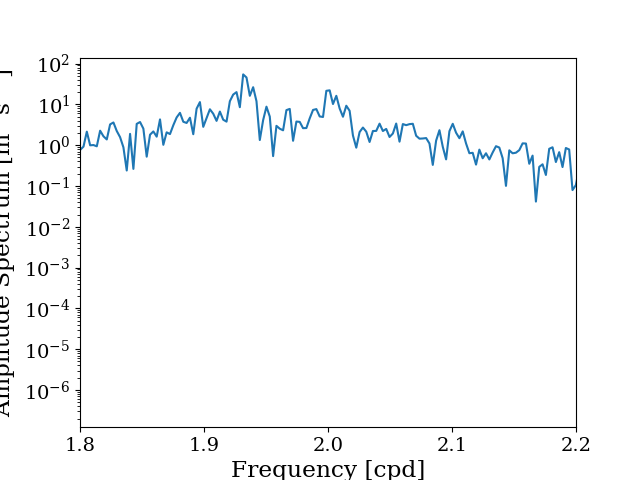

Text(0.5, 0, 'Frequency [cpd]')

In [111]:
# Interpolate onto a regular time grid
#dt = 3600
dt = 60
timeinterp = pd.date_range(A_n_1h.time.values[0],A_n_1h.time.values[-1],freq='{}s'.format(dt))
A_n_1h_i = A_n.to_xray().interp({'time':timeinterp})
#A_n_1h_i = A_n_1h.interp({'time':timeinterp})


tsec = timeinterp.view(int)*1e-9

f, S, df = power_spectra(tsec, A_n_1h_i.values, K=1 )
#f, S3, df = power_spectra(tsec, A_n_1h_i.values, K=3)

dt=60
fcpd = f*86400/(2*np.pi)

plt.figure()
plt.semilogy(fcpd,np.sqrt(S/dt)/dt)
#plt.xlim(0.5,4.5)
plt.xlim(1.8,2.2)

#plt.ylim(1e3,1e9)
plt.ylabel('Amplitude Spectrum [m$^2$ s$^{-1}$]')
plt.xlabel('Frequency [cpd]')

In [112]:
# Calculate the power spectrum for the inferred harmonic parameters
psd = []
amp = []
for ii in range(len(omega)):
    A = trace['beta_{}_re'.format(ii)] + 1j*trace['beta_{}_im'.format(ii)]
    psd.append(np.abs( A*np.conj(A))*86400*dt)
    amp.append(np.abs(A))
    
psd = np.array(psd)
amp = np.array(amp)
psd_mu = np.median(psd,axis=1)
psd_low = np.percentile(psd,5,axis=1)
psd_high = np.percentile(psd,95,axis=1)

amp_mu = np.median(amp,axis=1)
amp_low = np.percentile(amp,5,axis=1)
amp_high = np.percentile(amp,95,axis=1)

omega_cpd = np.array([ff/(2*np.pi) for ff in omega])

yerr = np.stack([amp_mu - amp_low, amp_high-amp_mu])
#yerr = amp_high-amp_low
yerr.shape, yerr, amp_mu

((2, 35), array([[0.12447827, 0.12531598, 0.13713675, 0.1288117 , 0.12018484,
         0.12609826, 0.12697324, 0.11905108, 0.12048659, 0.12090077,
         0.13314317, 0.13611578, 0.11953256, 0.12381782, 0.12637713,
         0.1153034 , 0.11980412, 0.1308285 , 0.09143792, 0.12464489,
         0.13646344, 0.10448634, 0.12642265, 0.1316348 , 0.12620615,
         0.11711694, 0.11240183, 0.0897203 , 0.11666914, 0.07014586,
         0.11270053, 0.12208711, 0.10361777, 0.08988271, 0.11269934],
        [0.12196513, 0.12481963, 0.12870954, 0.13632164, 0.12076894,
         0.11938231, 0.12705205, 0.11850017, 0.12149209, 0.12327112,
         0.12556377, 0.13377486, 0.11711222, 0.12641294, 0.11235509,
         0.1286688 , 0.12236748, 0.11891775, 0.11435054, 0.12023749,
         0.12273266, 0.11552892, 0.12282234, 0.12858072, 0.12495627,
         0.1163451 , 0.12127784, 0.11970289, 0.11692386, 0.09544144,
         0.12241293, 0.13226424, 0.12177956, 0.11249607, 0.11837448]]), array([ 2.45993525,  

<IPython.core.display.Javascript object>


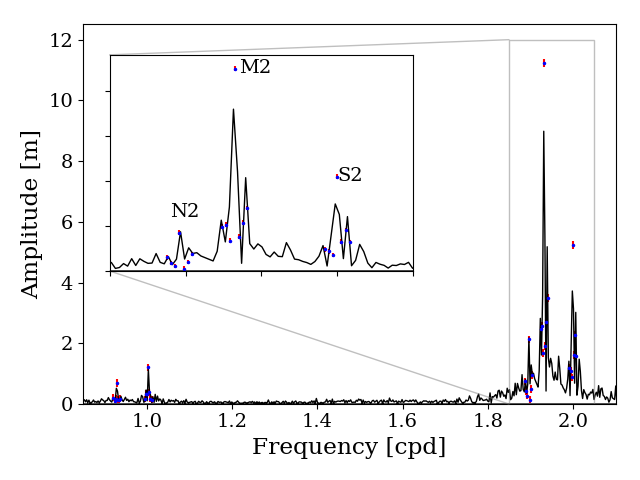

In [122]:
# Compute the fft amplitude directly
n = A_n_1h_i.values.shape[0]
#w = np.hamming(n)
#w = np.kaiser(n,8.6)
w= np.ones((n,))
wsum = 1/(np.sum(w)/n)
F = np.fft.fft(A_n_1h_i.values*w)
f = np.fft.fftfreq(n,dt)*2*np.pi # Hz
fcpd = f*86400/(2*np.pi)
#plt.figure()
#plt.plot(fcpd,2*np.abs(F)/n)

plt.figure()
ax = plt.subplot(111)
plt.plot(fcpd,2*np.abs(F)/n*wsum,'k',lw=1)
#plt.errorbar(omega_cpd, amp_mu, yerr=yerr, c='b',fmt='.')
plt.errorbar(omega_cpd, amp_mu, yerr=yerr, c='b', fmt='.', ms=3,ecolor='r')


plt.xlim(0.85,2.1)
#plt.xlim(1.85,2.05)
plt.ylim(1e-2,12.5)
plt.ylabel('Amplitude [m]')
plt.xlabel('Frequency [cpd]')

# inset axes....
axins = ax.inset_axes([0.05, 0.35, 0.57, 0.57])

axins.plot(fcpd,2*np.abs(F)/n*wsum,'k',lw=1)
#plt.plot(fcpd,2*np.sqrt(S3/dt)/(dt*2*np.pi),'k',lw=0.74)

axins.errorbar(omega_cpd, amp_mu, yerr=yerr, c='b', fmt='.', ms=3,ecolor='r')

# sub region of the original image
x1, x2, y1, y2 = 1.85,2.05, 0, 12
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.text(1.89,3,'N2')
axins.text(1.935,11,'M2')
axins.text(2.0,5,'S2')
plt.tight_layout()
ax.indicate_inset_zoom(axins)

plt.savefig('../FIGURES/a0_spectra_amp_{}.png'.format(sitename),dpi=150)
plt.savefig('../FIGURES/a0_spectra_amp_{}.pdf'.format(sitename),dpi=150)

<IPython.core.display.Javascript object>


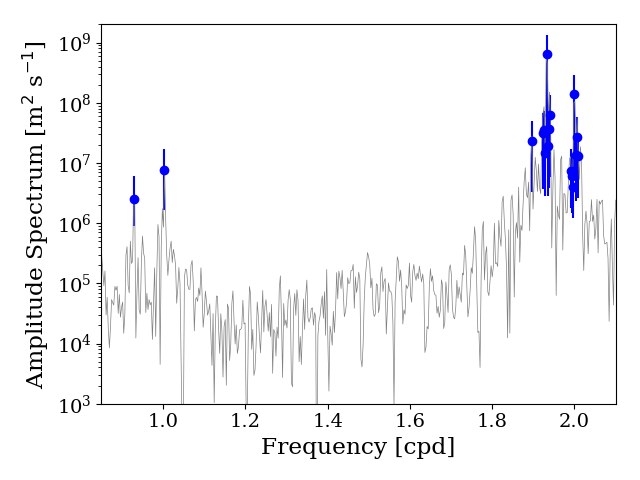

<IPython.core.display.Javascript object>


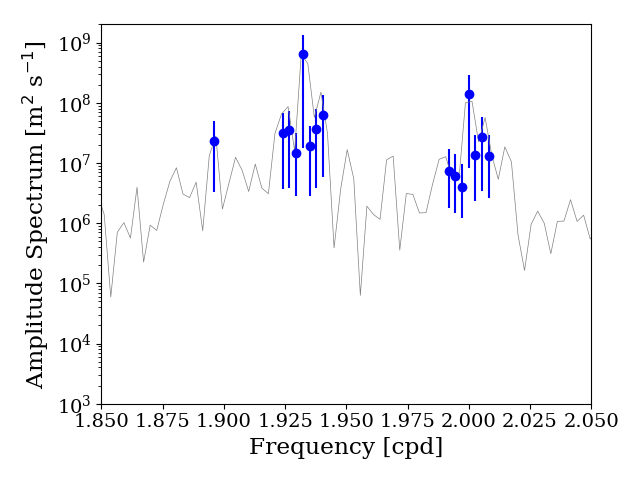

<IPython.core.display.Javascript object>


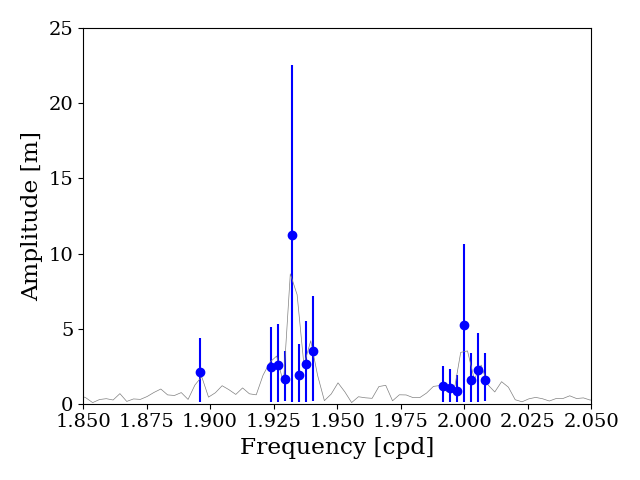

In [19]:
plt.figure()
plt.semilogy(fcpd,S,'0.5',lw=0.5)
#plt.semilogy(fcpd,S3,'k',lw=0.74)

plt.errorbar(omega_cpd, psd_mu, yerr=[psd_low, psd_high], c='b', fmt='o')
plt.xlim(0.85,2.1)
#plt.xlim(1.85,2.05)
plt.ylim(1e3,2e9)
plt.ylabel('Amplitude Spectrum [m$^2$ s$^{-1}$]')
plt.xlabel('Frequency [cpd]')

plt.tight_layout()

# plt.savefig('../FIGURES/a0_spectra_{}.png'.format(sitename),dpi=150)
# plt.savefig('../FIGURES/a0_spectra_{}.pdf'.format(sitename),dpi=150)


plt.figure()
plt.semilogy(fcpd,S,'0.5',lw=0.5)
#plt.semilogy(fcpd,S3,'k',lw=0.74)

plt.errorbar(omega_cpd, psd_mu, yerr=[psd_low, psd_high], c='b', fmt='o')
# plt.xlim(0.85,2.1)
plt.xlim(1.85,2.05)
plt.ylim(1e3,2e9)
plt.ylabel('Amplitude Spectrum [m$^2$ s$^{-1}$]')
plt.xlabel('Frequency [cpd]')

plt.tight_layout()

# plt.savefig('../FIGURES/a0_spectra_SD_{}.png'.format(sitename),dpi=150)
# plt.savefig('../FIGURES/a0_spectra_SD_{}.pdf'.format(sitename),dpi=150)

plt.figure()
plt.plot(fcpd,2*np.sqrt(S/dt)/(dt*2*np.pi),'0.5',lw=0.5)
#plt.plot(fcpd,2*np.sqrt(S3/dt)/(dt*2*np.pi),'k',lw=0.74)

plt.errorbar(omega_cpd, amp_mu, yerr=[amp_low, amp_high], c='b', fmt='o')
# plt.xlim(0.85,2.1)
plt.xlim(1.85,2.05)
plt.ylim(1e-2,25)
plt.ylabel('Amplitude [m]')
plt.xlabel('Frequency [cpd]')

plt.tight_layout()

# Short fit as a demonstration for SWOT proposal

In [14]:
tidecons = ['M2','S2','N2','K2','K1',]



frq,names = getTideFreq(tidecons)

basetime = datetime(2016,1,1)


A_n_sel = A_n_1h.sel(time=slice('2017-02-01','2017-05-01'))
idx = ~np.isnan(A_n_sel.values)
X = A_n_sel.values[idx] 
trace, my_model, omega, dtime, h_lsq = harmonic_fit_mcmc(A_n_sel.time.values[idx], X, frq, basetime=basetime)
pm.summary(trace)

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


{'sigma': 1.0, 'beta_amp_0': 12.061028110539207, 'beta_phs_0': -1.4699380139811349, 'beta_amp_1': 8.068883702592315, 'beta_phs_1': 0.41991900274006266, 'beta_amp_2': 2.2370887629520566, 'beta_phs_2': 2.837108660793149, 'beta_amp_3': 0.5752917510654437, 'beta_phs_3': 3.0949123931286606, 'beta_amp_4': 1.0750971102152895, 'beta_phs_4': 2.228228109047282}
Number of Parametrs: 11
 [12.14083317674681, 12.566370614359172, 11.912806035637455, 12.600776206127932, 6.300388082120014]


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -6,459.7, ||grad|| = 1.8953: 100%|██████████| 35/35 [00:00<00:00, 994.44it/s]   
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'beta_mean': array(0.01567946), 'beta_0_re': array(3.89700872), 'beta_0_im': array(11.40480765), 'beta_1_re': array(7.35956404), 'beta_1_im': array(3.28745778), 'beta_2_re': array(-2.22805008), 'beta_2_im': array(0.17455056), 'beta_3_re': array(-0.5792043), 'beta_3_im': array(0.02712078), 'beta_4_re': array(-0.65663523), 'beta_4_im': array(0.84928992), 'sigma_log__': array(1.556619), 'sigma': array(4.74275884)}


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_4_im, beta_4_re, beta_3_im, beta_3_re, beta_2_im, beta_2_re, beta_1_im, beta_1_re, beta_0_im, beta_0_re, beta_mean]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 261.39draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_mean,0.016546,0.105503,0.002408,-0.174492,0.227444,1803.099734,0.999252
beta_0_re,3.896638,0.139293,0.003370,3.629264,4.167440,1535.772229,0.999527
beta_0_im,11.405905,0.150556,0.003204,11.119333,11.688922,2427.718193,0.999000
beta_1_re,7.358901,0.191569,0.004581,7.014980,7.760096,1968.525895,0.999120
beta_1_im,3.272891,0.191556,0.005353,2.875702,3.620820,1189.546490,1.001547
beta_2_re,-2.228943,0.142285,0.003289,-2.500589,-1.951261,2021.609530,0.999264
beta_2_im,0.175072,0.139701,0.003659,-0.092391,0.431233,1507.151246,1.000140
beta_3_re,-0.579875,0.195561,0.004609,-0.956113,-0.202080,1636.223118,0.999200
beta_3_im,0.021804,0.194242,0.004866,-0.339933,0.411961,1528.923304,0.999348
beta_4_re,-0.658878,0.145359,0.003703,-0.964770,-0.376745,1904.200508,0.999058


In [11]:
tnew = A_n_sel.time.values[idx]
# Use the built-in function for prediction
nsamples = 500
ppc = pm.sample_posterior_predictive(trace, model=my_model, samples=nsamples)

a0_pred = ppc['X_obs']

100%|██████████| 500/500 [00:00<00:00, 533.92it/s]


In [32]:
plt.figure(figsize=(9,5))

#(A_n_sel/1000).plot(color='r',ls='-',lw=1)
plt.plot(dtime, A_n_sel.values/1000,'r')


plt.plot(dtime, np.median(a0_pred,axis=0)/1000,'k--')
#plt.plot(tnew, h_lsq,'k--')

plt.fill_between(dtime, np.percentile(a0_pred,5,axis=0)/1000,\
                 np.percentile(a0_pred,95,axis=0)/1000,color='b',alpha=0.5)

#plt.xlim(datetime(2017,3,25),datetime(2017,4,14))
# plt.fill_between(tnew, np.min(a0_pred,axis=0),\
#                  np.max(a0_pred,axis=0),color='b',alpha=0.3)
plt.xlabel('Time [d]')
plt.xlim(450,470)
plt.grid(b=True)
plt.ylabel('$h_{iw}$ [m]')
plt.legend(('Observed','Least-squares fit','90 % credible inteval'))
#plt.tight_layout()
plt.savefig('../FIGURES/Bayesian_SSH_example.png')

<IPython.core.display.Javascript object>

NameError: name 'A_n_sel' is not defined

# Build a hierarchical harmonic model

 - First level is the short term (15 d) harmonic fits (M2, S2, K1 ,O1)
 - Second level is the long-term variation of those harmonics

In [73]:
def harmonic_beta(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = tt.ones_like(tdays) * aa[...,None]
    for ii in range(nomega):
        amp += Aa[ii]*pm.math.cos(omega[ii]*tdays) + Ba[ii]*pm.math.sin(omega[ii]*tdays)
    
    return amp

def harmonic_beta_time(aa, Aa, Ba, omega, tdays, timeidx):
    nomega = len(omega)
    amp = tt.ones_like(tdays[timeidx]) * aa
    for ii in range(nomega):
        amp += Aa[timeidx,ii]*pm.math.cos(omega[ii]*tdays[timeidx]) +\
            Ba[timeidx,ii]*pm.math.sin(omega[ii]*tdays[timeidx])
    
    return amp

def harmonic_fit_mcmc_bhm(time,timeidx,timelow, X, frq, frqlow, basetime=None):

    """
    Harmonic fitting using Bayesian inference
    """
    tday = 86400.
    # Convert the time to days
    dtime = SecondsSince(time, basetime=basetime )
    dtime_low = SecondsSince(timelow, basetime=basetime )

    
    dtime /= tday
    dtime_low /= tday
    
    dtime = shared(dtime)
    dtime_low = shared(dtime_low)
    timeidx = shared(timeidx)
    
    # Convert the frequencies to radians / day
    omega = [ff*tday for ff in frq]
    omega_low = [ff*tday for ff in frqlow]

    #omega = frq
    
    # Number of parameters
    nomega = len(omega) 
    nomega_low = len(omega_low)
    nt = timelow.shape[0]
    
    print(nomega, nomega_low, nt)


    with pm.Model() as rho_model:

        # Harmonic decomposition on the real and imaginary components
        aa_l_i = pm.Normal('aa_l_i', mu=0, sd=5, shape=nomega_low)
        Aa_l_i = pm.Normal('Aa_l_i', mu=0, sd=5,shape=nomega_low)
        Ba_l_i = pm.Normal('Ba_l_i', mu=0, sd=5,shape=nomega_low)
        
        aa_l_r = pm.Normal('aa_l_r', mu=0, sd=5, shape=nomega_low)
        Aa_l_r = pm.Normal('Aa_l_r', mu=0, sd=5,shape=nomega_low)
        Ba_l_r = pm.Normal('Ba_l_r', mu=0, sd=5,shape=nomega_low)
        
        # This gives the amplitude of the low-frequency amplitudes
        sigma_beta = pm.HalfNormal('sigma_beta', sd=1.0, shape=nt)
        sigma_beta_a = pm.HalfNormal('sigma_beta_a', sd=1.0, shape=(nomega,nt))
        sigma_beta_b = pm.HalfNormal('sigma_beta_b', sd=1.0, shape=(nomega,nt))
        
        
        aa = pm.Normal('aa', mu=0, sd=sigma_beta, shape=nt)
        Aa = pm.Normal('Aa',mu=harmonic_beta(aa_l_i, Aa_l_i, Ba_l_i, omega_low, dtime_low),\
                    sd=sigma_beta_a, shape=(nomega,nt))
        Ba = pm.Normal('Ba',mu=harmonic_beta(aa_l_r, Aa_l_r, Ba_l_r, omega_low, dtime_low),\
                    sd=sigma_beta_b, shape=(nomega,nt))
        
        mu_x = harmonic_beta_time(aa, Aa, Ba, omega, dtime, timeidx)

        sigma_curve = pm.HalfNormal('sigma_curve', sd=2.0 )

        y_ = pm.Normal('y', mu=mu_x, sd=sigma_curve, observed=X)
        
        ###
        # Inference step

        trace = pm.sample(500, tune=1500, step=pm.NUTS(), cores=ncores, chains=nchains)

    return trace, rho_model

In [142]:
Xsel = A_n_1h.sel(time=slice('2016-05-02','2017-05-02'))
#Xsel.loc['2016-09-15':'2016-10-15']=np.nan
idx = ~np.isnan(Xsel.values)



X = Xsel.values[idx]
tnew = Xsel.time.values[idx]

# Break the time series up into chunks
trange = pd.date_range(tnew[0],tnew[-1],freq='15D').values
tmid = trange[0:-1] + 0.5*(trange[1:]-trange[0:-1])

tindex = np.zeros(tnew.shape, np.int)
ii=0
for t1,t2 in zip(trange[0:-1], trange[1:]):
    idx = (tnew>=t1) & (tnew<=t2)
    #print(t1,t2,sum(idx))

    tindex[idx] = ii
    ii+=1


<IPython.core.display.Javascript object>


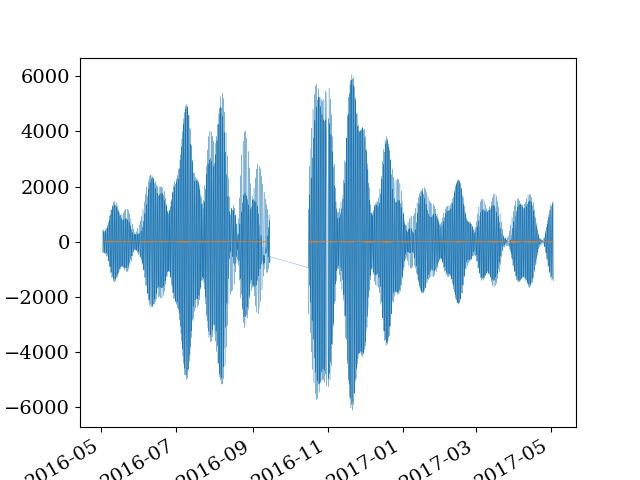

In [143]:
def harmonic_pred(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = np.ones_like(tdays) * aa
    for ii in range(nomega):
        amp += Aa[...,ii]*np.cos(omega[ii]*tdays) + Ba[...,ii]*np.sin(omega[ii]*tdays)
    
    return amp


tidecons = ['M2','S2','N2','K1','O1',]
frq,names = getTideFreq(tidecons)
#frqlow = [2*np.pi/(365*tdaysec), 2*np.pi/(180*tdaysec), 2*np.pi/(120*tdaysec)]
frqlow = [2*np.pi/(365*tdaysec), 2*np.pi/(180*tdaysec)]


# Go through and do the fitting using least-squares
nfrq = len(frq)
nfrqlow = len(frqlow)

tsec = SecondsSince(tnew)
tseclow = SecondsSince(tmid)

nt = tsec.shape[0]
ntlow = tseclow.shape[0]

# 1) Fit the tide harmonics to each 15 d block
aa = np.zeros((ntlow,))
Aa = np.zeros((ntlow, nfrq))
Ba = np.zeros((ntlow, nfrq))

for ii in range(ntlow):
    idx = tindex == ii
    Y = harmonic_fit_array(X[idx], tsec[idx], frq, axis=0)
    aa[ii] = Y[0]
    Aa[ii,:] = Y[1::2]
    Ba[ii,:] = Y[2::2]


# 2) Fit the low-frequency harmonics to these harmonics
aa_l_r = np.zeros((nfrq,))
Aa_l_r = np.zeros((nfrqlow,nfrq))
Ba_l_r = np.zeros((nfrqlow,nfrq))

aa_l_i = np.zeros((nfrq,))
Aa_l_i = np.zeros((nfrqlow,nfrq))
Ba_l_i = np.zeros((nfrqlow,nfrq))

#Y = harmonic_fit_array(aa, tseclow, frqlow, axis=0)
#aa_l_r[:] = Y[1::2]
#aa_l_i[:] = Y[2::2]

Y = harmonic_fit_array(Aa, tseclow, frqlow, axis=0)
aa_l_r[:] = Y[0,:]
Aa_l_r[:] = Y[1::2,:]
Aa_l_i[:] = Y[2::2,:]

Y = harmonic_fit_array(Ba, tseclow, frqlow, axis=0)
aa_l_i[:] = Y[0,:]
Ba_l_r[:] = Y[1::2,:]
Ba_l_i[:] = Y[2::2,:]

## Prediction
# 3) Build the tidal harmonics as a time-series
Aa_pred = np.zeros((nt,nfrq))
Ba_pred = np.zeros((nt,nfrq))

for ii in range(nfrq):
    Aa_pred[:,ii] = harmonic_pred(aa_l_r[ii], Aa_l_r[:,ii], Ba_l_r[:,ii], frqlow, tsec)
    Ba_pred[:,ii] = harmonic_pred(aa_l_i[ii], Aa_l_i[:,ii], Ba_l_i[:,ii], frqlow, tsec)


# 4) Predict the raw amplitude
a0 = harmonic_pred(0, Aa_pred, Ba_pred, frq, tsec)

plt.figure()
plt.plot(tnew,a0,lw=0.2)
Xsel.plot(lw=0.2)
#plt.plot(Ba_pred[:,1])

In [55]:
tdaysec = 86400
frqlow= [ 2*np.pi/(365*tdaysec), 2*np.pi/(182*tdaysec), 2*np.pi/(120*tdaysec)]

tidecons = ['M2','S2','N2','K1','O1',]
frq,names = getTideFreq(tidecons)

trace,  my_model = harmonic_fit_mcmc_bhm(tnew,tindex,tmid, X, frq, frqlow, basetime=basetime)
pm.summary(trace)

5 3 12


ValueError: operands could not be broadcast together with shapes (5,12) (3,12) 